In [16]:
%pip install pg8000

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install prophet
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
#from autonotebook import tqdm as notebook_tqdm
from prophet import Prophet

In [5]:
url = URL.create(
    "postgresql+pg8000",
    username=os.environ.get('DB_USER'),
    password=os.environ.get('DB_PASSWORD'),
    host=os.environ.get('DB_HOST'),
    database=os.environ.get('DB_NAME')
)

engine = create_engine(url)

In [6]:
with engine.connect() as conn:
    weather_station_coords = pd.read_sql(sql=text("SELECT DISTINCT latitude, longitude FROM weather_historical;"), con=conn)

In [7]:
with engine.connect() as conn:
    population_centers = pd.read_sql(sql=text("SELECT * FROM population_centers WHERE center_name IN ('boston', 'hartford');"), con=conn)   

In [8]:
weather_station_coords['type'] = "weather_station"
population_center_coords = population_centers[['latitude', 'longitude']]
population_center_coords['type'] = "population_center"
all_coords = pd.concat([population_center_coords, weather_station_coords], axis=0, ignore_index=True)

/tmp/ipykernel_12342/3508199798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_center_coords['type'] = "population_center"


(-73.76439500000001, -67.507705, 40.85194, 47.59186)

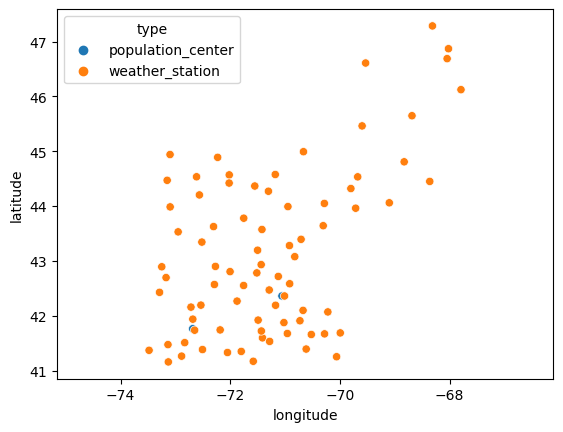

In [9]:
sns.scatterplot(all_coords, x='longitude', y='latitude', hue='type')
plt.axis('equal')

In [10]:
all_coords

,latitude,longitude,type
0,42.361145,-71.05708,population_center
1,41.763710,-72.68510,population_center
2,42.191200,-71.17330,weather_station
3,43.985500,-73.09550,weather_station
4,41.741900,-72.18360,weather_station
...,...,...,...
77,42.098200,-70.67210,weather_station
78,42.570100,-72.28860,weather_station
79,41.158300,-73.12890,weather_station
80,42.893500,-73.24860,weather_station


<Axes: xlabel='longitude', ylabel='latitude'>

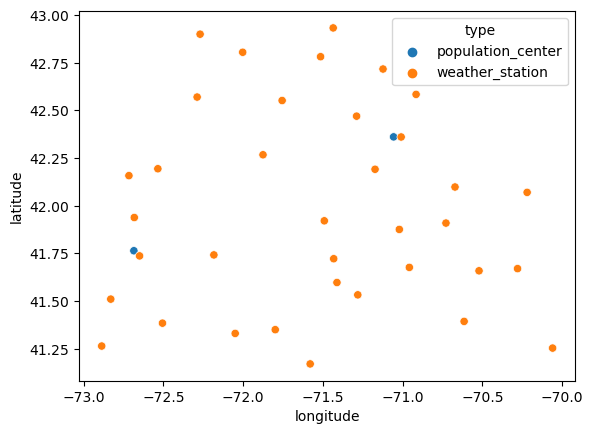

In [11]:
relevant_points = all_coords[(all_coords['latitude'].between(41, 43)) & (all_coords['longitude'].between(-73, -70))]
sns.scatterplot(relevant_points, x='longitude', y='latitude', hue='type')

In [12]:
c = cdist(relevant_points.loc[relevant_points['type'] == 'weather_station', ['longitude', 'latitude']], relevant_points.loc[relevant_points['type'] == 'population_center', ['longitude', 'latitude']], 'euclidean')
distances = pd.DataFrame(c, columns=['distance_to_boston', 'distance_to_hartford'])

In [13]:
distances

,distance_to_boston,distance_to_hartford
0,0.205884,1.571078
1,1.285501,0.501974
2,1.431485,0.769062
3,0.621658,1.551164
4,1.710384,0.044766
5,0.883491,2.166157
6,0.685669,1.711073
7,1.747595,0.419962
8,1.490414,2.674004
9,0.724291,1.218541


(-0.05692527596842474,
 2.2378597520050385,
 -0.08669548755736906,
 2.8054659234720445)

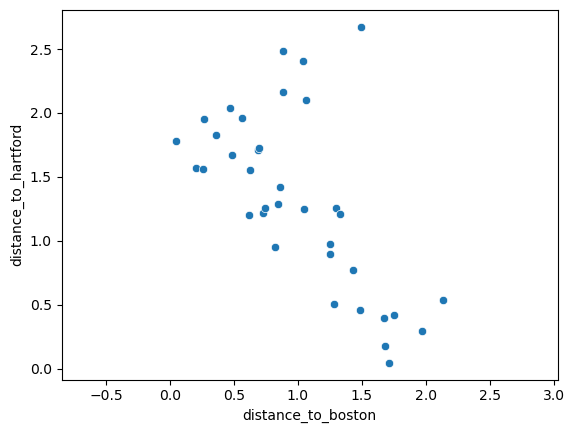

In [14]:
g = sns.scatterplot(distances, x='distance_to_boston', y='distance_to_hartford')
plt.axis('equal')

In [15]:
X = distances.to_numpy()

In [16]:
distortions = []
inertias = []
silhouettes = []
mapping1 = {}
mapping2 = {}
mapping3 = {}
labels = {}

cluster_amount = range(2, 15)
for n in cluster_amount:
    kmeans = KMeans(n_clusters=n, n_init=10)
    kmeans.fit(X)
    silhouettes.append(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'))
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeans.inertia_)
    mapping1[n] = sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
    mapping2[n] = kmeans.inertia_
    mapping3[n] = metrics.silhouette_score(X, kmeans.labels_, metric='euclidean')
    labels[n] = kmeans.labels_

<Axes: >

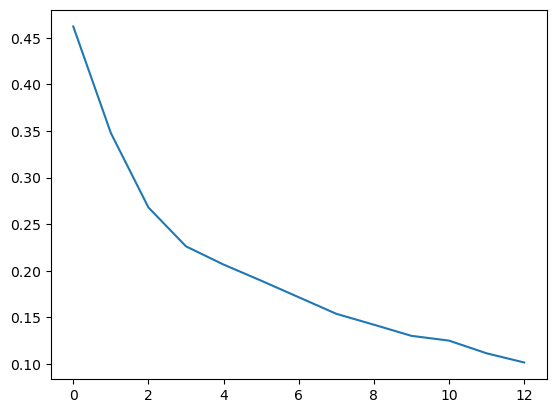

In [17]:
sns.lineplot(distortions)

<Axes: >

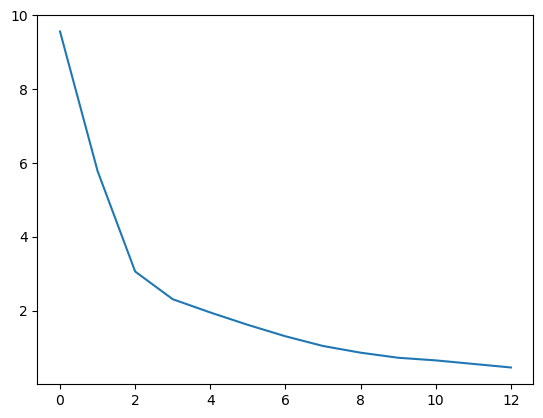

In [18]:
sns.lineplot(inertias)

<Axes: >

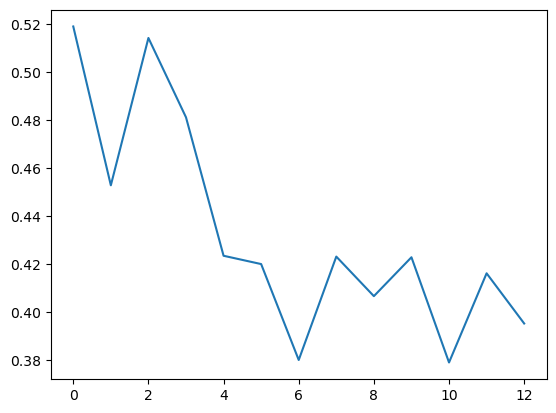

In [19]:
sns.lineplot(silhouettes)

In [20]:
labels[2]

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int32)

In [21]:
relevant_points['label'] = 'population_center'
relevant_points.loc[2:, 'label'] = labels[2]
relevant_points

/tmp/ipykernel_12342/1591246521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_points['label'] = 'population_center'


,latitude,longitude,type,label
0,42.361145,-71.05708,population_center,population_center
1,41.763710,-72.68510,population_center,population_center
2,42.191200,-71.17330,weather_station,0
4,41.741900,-72.18360,weather_station,1
7,41.330000,-72.05000,weather_station,1
8,42.781800,-71.51480,weather_station,0
9,41.736700,-72.64940,weather_station,1
10,41.658500,-70.52150,weather_station,0
11,42.932800,-71.43570,weather_station,0
15,41.383900,-72.50590,weather_station,1


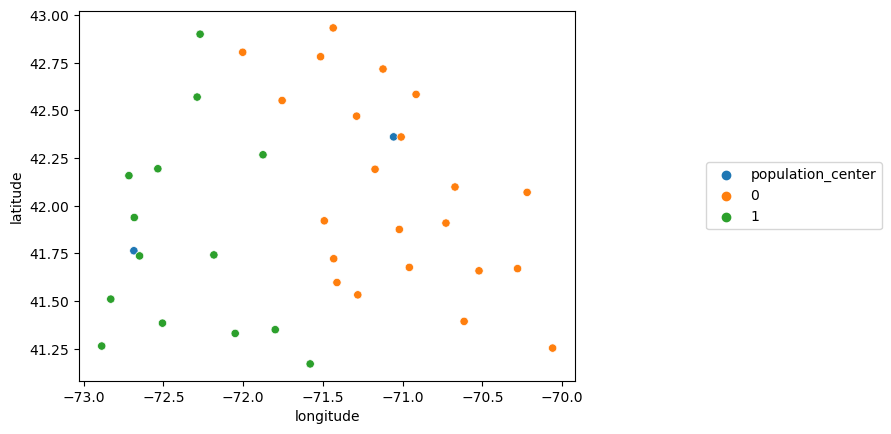

In [22]:
g = sns.scatterplot(relevant_points, x='longitude', y='latitude', hue='label')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

In [23]:
hartford_area = tuple(relevant_points.loc[relevant_points['label'] == 1, ['latitude', 'longitude']].itertuples(index=False, name=None))
boston_area = tuple(relevant_points.loc[relevant_points['label'] == 0, ['latitude', 'longitude']].itertuples(index=False, name=None))
area_params = [boston_area, hartford_area]

In [22]:
dfs = list()

with engine.connect() as conn:
    for params in area_params:
        values = ", ".join(str((str(lat), str(lon))) for (lat, lon) in params)
        stmt = '''SELECT 
            weather_datetime, 
            AVG(NULLIF(apparent_temperature, 'NaN')) apparent_temperature_avg, 
            AVG(NULLIF(air_temperature, 'NaN')) air_temperature_avg, 
            AVG(NULLIF(dewpoint_temperature, 'NaN')) dewpoint_temperature_avg,
            AVG(NULLIF(relative_humidity, 'NaN')) relative_humidity_avg,
            AVG(NULLIF(total_precipitation, 'NaN')) total_precipitation_avg, 
            AVG(NULLIF(wind_speed, 'NaN')) wind_speed_avg
            FROM weather_historical
            WHERE (latitude, longitude) IN ({})
            GROUP BY weather_datetime
            ORDER BY weather_datetime ASC;'''.format(values)
        df = pd.read_sql(sql=text(stmt), con=conn)
        dfs.append(df)

In [23]:
with engine.connect() as conn:
    load_historical = pd.read_sql(sql=text("SELECT DISTINCT load_datetime, load_mw FROM grid_load;"), con=conn)

In [24]:
stmt = """SELECT DISTINCT gf.forecasted_at, gf.forecasted_for, gf.load_mw FROM grid_forecast gf 
INNER JOIN (SELECT MAX(forecasted_at) MaxDate, forecasted_for FROM grid_forecast group by forecasted_for) tm
ON tm.forecasted_for = gf.forecasted_for AND gf.forecasted_at = tm.MaxDate;"""
with engine.connect() as conn:
    load_forecast = pd.read_sql(sql=text(stmt), con=conn)

In [25]:
boston_area_weather = dfs[0].rename(columns={c:'boston_area_'+c for c in dfs[0].columns if c not in ['weather_datetime']})
hartford_area_weather = dfs[1].rename(columns={c:'hartford_area_'+c for c in dfs[1].columns if c not in ['weather_datetime']})

In [26]:
two_cluster_weather = boston_area_weather.merge(hartford_area_weather, on='weather_datetime', how='inner')
two_cluster_weather['weather_datetime'] = two_cluster_weather['weather_datetime'].astype('datetime64')

In [30]:
load_historical = load_historical.drop_duplicates()

In [31]:
data = (
    two_cluster_weather
    .merge(
        load_historical, 
        left_on='weather_datetime', 
        right_on='load_datetime', 
        how='inner', indicator=True)
    .drop(columns=['_merge', 'weather_datetime'])
)

In [43]:
os.listdir('work/New-England-Load-Forecasting/')

['.git', 'New-England-Load-Forecasting']

In [28]:
load_forecast.to_csv('work/New-England-Load-Forecasting/analysis/official_forecasts.csv')

In [39]:
data = pd.read_csv('../analysis/clean_data.csv', index_col=0)

['.bash_logout',
 '.bashrc',
 '.profile',
 '.cache',
 '.local',
 '.ipython',
 '.ipynb_checkpoints',
 '.config',
 '.conda',
 '.jupyter',
 '.npm',
 '.wget-hsts',
 'work']

In [29]:
data = pd.read_csv('work/New-England-Load-Forecasting/analysis/clean_data.csv', index_col=0)

In [30]:
data['load_datetime'] = pd.to_datetime(data['load_datetime'])
data['is_weekday'] = np.where(data['load_datetime'].dt.dayofweek >= 5, 0, 1)

In [31]:
prophet_train = data.loc[data['load_datetime'] <= '2023-03-10',['load_datetime','boston_area_apparent_temperature_avg', 'hartford_area_apparent_temperature_avg', 'load_mw', 'is_weekday']].rename({'load_datetime': 'ds', 'load_mw': 'y'}, axis=1).sort_values('ds')
prophet_test = data.loc[data['load_datetime'] > '2023-03-10',['load_datetime','boston_area_apparent_temperature_avg', 'hartford_area_apparent_temperature_avg', 'load_mw', 'is_weekday']].rename({'load_datetime': 'ds', 'load_mw': 'y'}, axis=1).sort_values('ds')

In [32]:
import itertools
from prophet.diagnostics import performance_metrics, cross_validation
param_grid = {
    'changepoint_prior_scale': [.001, .01, .1, .5],
    'seasonality_prior_scale': [.01, .1, 1, 10, 100]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

In [33]:
for params in all_params:
    m = Prophet(**params)
    m.add_country_holidays(country_name='US')
    m.add_regressor('boston_area_apparent_temperature_avg')
    m.add_regressor('hartford_area_apparent_temperature_avg')
    m.add_regressor('is_weekday')
    m.fit(prophet_train)
    df_cv = cross_validation(m, initial='1460 days', horizon='7 days', period='24 hours', parallel='threads')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

17:59:03 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1] done processing


: 

: 

In [ ]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

In [93]:
predictions = m.predict(prophet_test)

In [89]:
load_forecast

,forecasted_at,forecasted_for,load_mw
0,2019-01-01 09:42:02,2019-01-01 00:00:00,11500.0
1,2019-01-01 09:42:02,2019-01-01 01:00:00,10960.0
2,2019-01-01 09:42:02,2019-01-01 02:00:00,10560.0
3,2019-01-01 09:42:02,2019-01-01 03:00:00,10300.0
4,2019-01-01 09:42:02,2019-01-01 04:00:00,10250.0
...,...,...,...
37094,2023-03-24 09:23:39,2023-03-26 19:00:00,13500.0
37095,2023-03-24 09:23:39,2023-03-26 20:00:00,13070.0
37096,2023-03-24 09:23:39,2023-03-26 21:00:00,12350.0
37097,2023-03-24 09:23:39,2023-03-26 22:00:00,11560.0


In [94]:
merged_predictions = predictions[['ds', 'yhat']].merge(prophet_test[['y', 'ds']]).merge(load_forecast[['load_mw', 'forecasted_for']].rename(columns={'load_mw': 'iso_forecast', 'forecasted_for': 'ds'}), on='ds').set_index('ds')
merged_predictions

,yhat,y,iso_forecast
ds,,,
2023-03-20 01:00:00,9918.121282,11962.518,11090.0
2023-03-20 02:00:00,9761.776423,11886.617,11040.0
2023-03-20 03:00:00,9766.263252,11953.694,11060.0
2023-03-20 04:00:00,10030.528224,12109.241,11430.0
2023-03-20 05:00:00,10560.641525,12589.660,12300.0
...,...,...,...
2023-03-23 19:00:00,14078.204868,13881.286,13940.0
2023-03-23 20:00:00,13476.535604,13472.341,13450.0
2023-03-23 21:00:00,12546.971613,12674.921,12630.0


<Axes: xlabel='ds'>

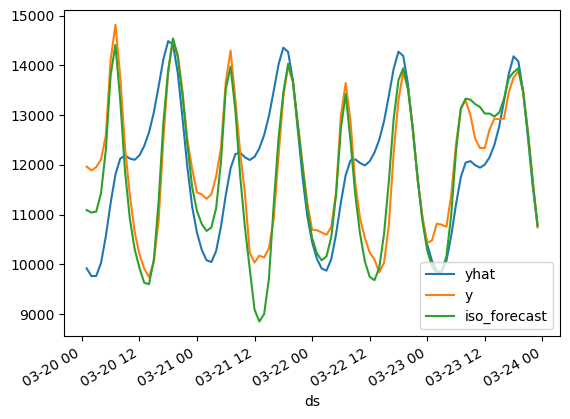

In [95]:
merged_predictions.plot()

In [71]:
((merged_predictions[:'2023-03-20']['y'] - merged_predictions[:'2023-03-20']['yhat']) < (merged_predictions[:'2023-03-20']['y'] - merged_predictions[:'2023-03-20']['iso_forecast'])).value_counts()

False    13
True     10
dtype: int64

<Axes: xlabel='ds'>

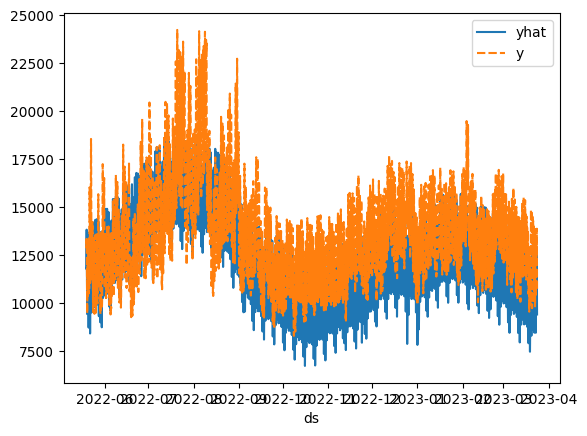

In [72]:
sns.lineplot(merged_y_yhat)

In [51]:
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-05-19 10:00:00,12648.668211,10046.587328,13567.149176,12648.668211,12648.668211,0.0,0.0,0.0,0.0,...,233.259529,233.259529,233.259529,-1716.255273,-1716.255273,-1716.255273,0.0,0.0,0.0,11835.692309
1,2022-05-19 11:00:00,12648.441904,9888.312901,13530.104471,12648.441904,12648.441904,0.0,0.0,0.0,0.0,...,227.453181,227.453181,227.453181,-1713.741283,-1713.741283,-1713.741283,0.0,0.0,0.0,11790.086321
2,2022-05-19 12:00:00,12648.215597,10170.491367,13513.653830,12648.215597,12648.215597,0.0,0.0,0.0,0.0,...,221.259015,221.259015,221.259015,-1711.218789,-1711.218789,-1711.218789,0.0,0.0,0.0,11842.134383
3,2022-05-19 13:00:00,12647.989291,10225.408691,13702.879073,12647.989291,12647.989291,0.0,0.0,0.0,0.0,...,214.725061,214.725061,214.725061,-1708.687806,-1708.687806,-1708.687806,0.0,0.0,0.0,11978.674234
4,2022-05-19 14:00:00,12647.762984,10419.968719,13802.275666,12647.762984,12647.762984,0.0,0.0,0.0,0.0,...,207.898860,207.898860,207.898860,-1706.148348,-1706.148348,-1706.148348,0.0,0.0,0.0,12189.353706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7399,2023-03-23 19:00:00,10973.770709,2271.715040,21778.907783,419.928790,19976.388934,0.0,0.0,0.0,0.0,...,170.900160,170.900160,170.900160,-1073.701535,-1073.701535,-1073.701535,0.0,0.0,0.0,12732.469586
7400,2023-03-23 20:00:00,10973.544402,1332.098645,21165.461283,415.969683,19977.910852,0.0,0.0,0.0,0.0,...,163.179898,163.179898,163.179898,-1075.733095,-1075.733095,-1075.733095,0.0,0.0,0.0,12136.100654
7401,2023-03-23 21:00:00,10973.318095,989.727646,20272.858510,412.010575,19979.432769,0.0,0.0,0.0,0.0,...,155.414513,155.414513,155.414513,-1077.759650,-1077.759650,-1077.759650,0.0,0.0,0.0,11209.278897
7402,2023-03-23 22:00:00,10973.091788,-498.804782,19292.367560,408.051468,19980.954687,0.0,0.0,0.0,0.0,...,147.618755,147.618755,147.618755,-1079.781204,-1079.781204,-1079.781204,0.0,0.0,0.0,10221.880239


In [53]:
prophet_test

,ds,boston_area_apparent_temperature_avg,hartford_area_apparent_temperature_avg,y,is_weekday
29620,2022-05-19 10:00:00,54.828572,52.665833,13117.797,1
29621,2022-05-19 11:00:00,54.890477,52.884615,13199.001,1
29622,2022-05-19 12:00:00,55.145455,52.942307,13205.589,1
29623,2022-05-19 13:00:00,55.404546,53.140769,13116.635,1
29624,2022-05-19 14:00:00,55.382273,53.659230,12934.000,1
...,...,...,...,...,...
37019,2023-03-23 19:00:00,52.330476,50.293076,13881.286,1
37020,2023-03-23 20:00:00,49.870476,49.656154,13472.341,1
37021,2023-03-23 21:00:00,49.795238,50.168461,12674.921,1
37022,2023-03-23 22:00:00,49.491905,50.516153,11677.522,1
